## Intro

Foundational mapping is perhaps one of the main applications of Deep Learning and in particular, semantic segmentation. Among the framework data, roads are perhaps the most important one.

The road length of our planet is about 33 million km (paved and unpaved) roads are paved and expanded every day so satellite imaging is extensively used to extract them and it is virtually impossible to keep up with the ever-expanding road network with manpower to manually map all.

Since roads look visually similar to rivers and railways. Road extraction by classical computer vision algorithms may not yield the best results as they are dependent on features extracted from the image. Deep learning has shown a significant performance and accuracy gain in the field of computer vision compared to classical computer vision algorithms. So, we will be using deep neural networks to extract roads from overhead images.

The Massachussets Roads dataset was introduced in Chapter 6 of this PhD thesis by Volodymyr Mnih, 2013. See the [Thesis](https://www.cs.toronto.edu/~vmnih/docs/Mnih_Volodymyr_PhD_Thesis.pdf) for more details.

Aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers, in tiff format.

Mask — Labeled image, created from the original image by assigning a different pixel value to the feature that is to be segmented from its surroundings. 1 road, 0 background

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"
base_dir = root_dir + 'deep_learning/U-Net/Massachussets_Roads_Dataset/'
print("base_dir is: ", base_dir)

Mounted at /content/drive
base_dir is:  /content/drive/My Drive/deep_learning/U-Net/Massachussets_Roads_Dataset/


In [ ]:
%env SM_FRAMEWORK = tf.keras
!pip install segmentation_models

env: SM_FRAMEWORK=tf.keras
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 8.2 MB/s 


In [ ]:
# Keras importing libraries
from keras import callbacks, optimizers
from keras.models import Model, load_model, model_from_json
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, Flatten, BatchNormalization, Conv2DTranspose, Concatenate, Dropout
from keras.callbacks import ModelCheckpoint
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import segmentation_models as sm

# Importing other libraries
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

print('all libraries have been imported successfully')

Segmentation Models: using `tf.keras` framework.
all libraries have been imported successfully


## Pre-processing Data

A handful of images were missing a portion of their data.

Incomplete images will degrade the performance of the model, so we will be removing images that are missing more than 10% of its data.

![An image](https://miro.medium.com/max/1050/1*BIc6NoqLG6TRnQDd9PGXiA.png)

In [ ]:
f_ext2 ='tiff'
mypath2 = os.path.join(base_dir, 'train_labels/')

for i, f in enumerate(os.listdir(mypath2)):
    f_name, f_ext = os.path.splitext(f)
    #print(f_name, f_ext)
    new_name = f_name + '.' + f_ext2
    print(mypath2 + f)
    os.rename(mypath2 + f, mypath2 + new_name)

/content/drive/My Drive/deep_learning/U-Net/Massachussets_Roads_Dataset/train_labels/11278870_15.tiff
/content/drive/My Drive/deep_learning/U-Net/Massachussets_Roads_Dataset/train_labels/11278780_15.tiff
/content/drive/My Drive/deep_learning/U-Net/Massachussets_Roads_Dataset/train_labels/11278675_15.tiff
/content/drive/My Drive/deep_learning/U-Net/Massachussets_Roads_Dataset/train_labels/11278750_15.tiff
/content/drive/My Drive/deep_learning/U-Net/Massachussets_Roads_Dataset/train_labels/11278690_15.tiff
/content/drive/My Drive/deep_learning/U-Net/Massachussets_Roads_Dataset/train_labels/11278720_15.tiff
/content/drive/My Drive/deep_learning/U-Net/Massachussets_Roads_Dataset/train_labels/11278855_15.tiff
/content/drive/My Drive/deep_learning/U-Net/Massachussets_Roads_Dataset/train_labels/11278735_15.tiff
/content/drive/My Drive/deep_learning/U-Net/Massachussets_Roads_Dataset/train_labels/11278930_15.tiff
/content/drive/My Drive/deep_learning/U-Net/Massachussets_Roads_Dataset/train_labe

In [ ]:
import shutil, os
import cv2
import numpy as np

#Function to store images that are missing less than 10% of size
def preprocess(mythreshold):
  mypath = os.path.join(base_dir, 'train/')
  mypath2 = os.path.join(base_dir, 'train_labels/')
  complete_image_path = os.path.join(base_dir, 'train_complete/')
  mask_path = os.path.join(base_dir, 'train_labels_complete/')
  for filename in os.listdir(mypath):
    print(mypath)
    print(mypath+filename)
    print(mypath2+filename)
    img = cv2.imread(mypath + filename, cv2.IMREAD_GRAYSCALE)
    #img_path = os.path.join(meta, [i])
    #msk_path = os.path.join(meta, [i])
    #image = cv2.imread(img_path)
    #converting the image to grayscale
    #my_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    #counting number of white pixels to size of blank part of the image
    if (np.sum(img==255)/(1500*1500)) > mythreshold:
      shutil.copy(mypath + filename, complete_image_path)
      shutil.copy(mypath2 + filename, mask_path)
  #print(mask_path)
  return

preprocess(0.1)

Resizing images of 1500x1500 to smaller dimensions (resampling) will not preserve all the information of the original image, so instead images are cropped (tessellated) into smaller images, i.e. (512x512 or 256x256).

![An image](https://miro.medium.com/max/1050/1*epLUs0Vre9hIrjcFLfO-Dg.png)

## The architecture: The U-Net
It is a convolutional neural network originally developed for segmenting biomedical images. When visualized the architecture of U-Net resembles the letter U hence the name. U-Net consists of 2 two major parts, the left part is called the contracting path, and the right part is the expansive path.
[U-Net Paper](https://arxiv.org/abs/1505.04597)

![An image](https://miro.medium.com/max/1050/1*L3XupbaNbOdBfAsEg1Y3YA.png)

We can compute the spatial size of the output volume as a function of the input volume size (W), the receptive field size of the Conv Layer neurons (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The size of the output is given by [(W−F+2P)/S] + 1. For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

What is then a 1x1 convolution?

(W−F+2P)/S+1 =
(388-1+0)/1 + 1 = 388-1+1 = 388

![imagen](https://miro.medium.com/max/929/1*qv3mEYb0Vvws_SsfgnMq_Q.png)

## Model Architecture without metric and loss
U-net with 2 million parameters was used as segmentation model. Use model.summary() to check that out !

## Performance Metric (IoU Score) = Jaccard Index
It measures the overlap between 2 boxes the predicted and ground pixels in a segmentation task, it ranges between 0 and 1. IoU of 0 denotes that there is no overlap between the boxes, IoU of 1 means that the union of the boxes is the same as their overlap indicating that prediction and ground truth are the 'same'.

![IoU](https://miro.medium.com/max/710/0*A591QJ9zZfeoMaxv.png)

In [ ]:
def dice_coef(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
def mIoU(y_pred, y_true):
   I = K.reduce_sum(y_pred * y_true, axis=(1, 2))
   U = K.reduce_sum(y_pred + y_true, axis=(1, 2)) - I
   return K.reduce_mean(I / U)

In [ ]:
input_layer = keras.layers.Input(shape=(512,512,3))

# Block 1
x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
x = BatchNormalization()(x)
block_1_out = Activation('relu')(x)
x = MaxPooling2D()(block_1_out)
x = Dropout(0.2)(x)

# Block 2
x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
x = BatchNormalization()(x)
block_2_out = Activation('relu')(x)
x = MaxPooling2D()(block_2_out)
x = Dropout(0.2)(x)

# Block 3
x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
x = BatchNormalization()(x)
block_3_out = Activation('relu')(x)
x = MaxPooling2D()(block_3_out)
x = Dropout(0.2)(x)

# Block 4
x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)  # padding same means 0, zero, zilch, nothing !
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

block_4_out = Activation('relu')(x)

x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP2')(block_4_out)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Concatenate()([x, block_3_out])
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

# UP 3
x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP3')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Concatenate()([x, block_2_out])
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

# UP 4
x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP4')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Concatenate()([x, block_1_out])
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
pred = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

model = Model(inputs=[input_layer], outputs=[pred])
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef, sm.metrics.iou_score])
#print(model.summary())


model saved: /content/drive/My Drive/deep_learning/U-Net/Massachussets_Roads_Dataset/model.hdf5


Loss Function (Dice Coefficient): The Dice coefficient is very similar to the IoU. They are positively correlated. The dice Coefficient also ranges from 0 to 1.

Dice Coefficient is 2 * the Area of Overlap divided by the total number of pixels in both images.  512*512 images are used to train the model using DICE loss, 20% of the data is set for validation purposes. Model converges after X epochs.

## Training

(512, 512, 3)


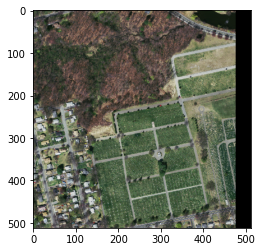

(512, 512)


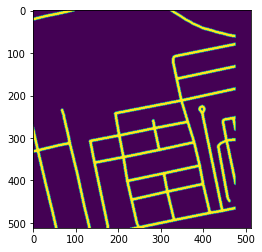

In [ ]:
# Let's see an example of training images
img = plt.imread(base_dir + 'train_crop/'+ '277.tiff')
msk = plt.imread(base_dir + 'train_labels_crop/'+ '277.tiff')
print(img.shape)
plt.imshow(img)
plt.show()
plt.imshow(msk)
print(msk.shape)

In [ ]:
# Let's create two lists one for img one for msk, I like both images in one, we will see that later !
import os

def build_data(PATH):
    data = []
    filenames = sorted(os.listdir(PATH))
    for name in filenames:
        data.append(PATH + '/' + name)
    print('-> number of images:', len(data))
    return data


TRAIN_PATH = base_dir + 'train_crop/'
LABEL_PATH = base_dir + 'train_labels_crop/'

img = build_data(TRAIN_PATH)  # an instantiation of build_data fn
msk = build_data(LABEL_PATH)

-> number of images: 1276
-> number of images: 1276


In [ ]:
import pandas as pd

df = pd.DataFrame({
    'Image' : img,
    'Mask' : msk
})

df.head()


,Image,Mask
0,/content/drive/My Drive/deep_learning/U-Net/Ma...,/content/drive/My Drive/deep_learning/U-Net/Ma...
1,/content/drive/My Drive/deep_learning/U-Net/Ma...,/content/drive/My Drive/deep_learning/U-Net/Ma...
2,/content/drive/My Drive/deep_learning/U-Net/Ma...,/content/drive/My Drive/deep_learning/U-Net/Ma...
3,/content/drive/My Drive/deep_learning/U-Net/Ma...,/content/drive/My Drive/deep_learning/U-Net/Ma...
4,/content/drive/My Drive/deep_learning/U-Net/Ma...,/content/drive/My Drive/deep_learning/U-Net/Ma...


In [ ]:
# There are 3 ways to perform data augmentation: 1. when producing dataset
# 2. during training in Keras
# 3. Using a library

# There is also albumentations 3d
!pip install  albumentations


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import albumentations as A
transform = A.Compose([
    A.HorizontalFlip(p=0.5), A.RandomCrop(height = 512, width = 512, p = 1)
])

In [ ]:
def scale_function(img, msk):
    img, msk = plt.imread(img.decode()), plt.imread(msk.decode())
    img = img/255.0
    msk = msk/255.0
    transformed = transform(image=img, mask=msk)
    img = transformed['image']
    msk = transformed['mask']
    return img.astype(np.float64), msk.astype(np.float64)


In [ ]:
import tensorflow as tf

BATCH_SIZE = 4  # small because images are big, 512x512 px, you have two options, decrease the 'bs' or decrease the image size

def create_dataset(data):
    dataset = tf.data.Dataset.from_tensor_slices((data['Image'], data['Mask']))
    dataset = dataset.shuffle(1000)
    dataset = dataset.map(lambda img, msk : tf.numpy_function(
                    scale_function, [img, msk], [tf.float64, tf.float64]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset

(4, 512, 512, 3) (4, 512, 512)


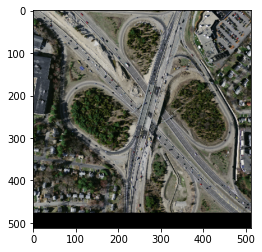

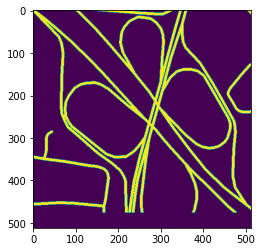

In [ ]:
train_dataset = create_dataset(df)
img, msk = next(iter(train_dataset))
print(img.shape, msk.shape)

plt.imshow(img[1])
plt.show()
plt.imshow(msk[1])
plt.show()

In [ ]:
model.fit(train_dataset, epochs = 20, batch_size=32, verbose=1)
mymodel = os.path.join(base_dir, 'model.hdf5')
model.save(mymodel)
print("model saved:", mymodel)

Epoch 1/20
319/319 [==============================] - 303s 950ms/step - loss: 0.2193 - dice_coef: 0.7807 - iou_score: 0.6423
Epoch 2/20
319/319 [==============================] - 303s 950ms/step - loss: 0.2211 - dice_coef: 0.7789 - iou_score: 0.6400
Epoch 3/20
319/319 [==============================] - 304s 951ms/step - loss: 0.2179 - dice_coef: 0.7820 - iou_score: 0.6442
Epoch 4/20
319/319 [==============================] - 303s 951ms/step - loss: 0.2167 - dice_coef: 0.7833 - iou_score: 0.6458
Epoch 5/20
319/319 [==============================] - 303s 951ms/step - loss: 0.2148 - dice_coef: 0.7852 - iou_score: 0.6483
Epoch 6/20
319/319 [==============================] - 304s 951ms/step - loss: 0.2143 - dice_coef: 0.7857 - iou_score: 0.6493
Epoch 7/20
319/319 [==============================] - 303s 951ms/step - loss: 0.2143 - dice_coef: 0.7857 - iou_score: 0.6488
Epoch 8/20
319/319 [==============================] - 303s 951ms/step - loss: 0.2127 - dice_coef: 0.7873 - iou_score: 0.6510


## Load model & Inference

In [ ]:
# load trained model

model = load_model(mymodel)
model.predict(img_test_path)
